In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
adata = sc.read_h5ad("merscope_855_notscaled.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 15927370 × 300
    obs: 'n_counts', 'sample', 'region', 'gw'
    uns: 'rank_genes_groups'
    obsm: 'spatial'


(15927370, 300)

In [2]:
adata_scaled = sc.read_h5ad("merscope_855.h5ad")
print(adata_scaled)

In [13]:
adata.obs.index = adata.obs.index.map(lambda x: x.split('-')[0])
adata.obs['H3_annotation'] = adata_scaled.obs['H3_annotation']
print(adata.obs['H3_annotation'].head())

In [70]:
clusters_of_interest = ['EN-ET-SP-A', 'EN-ET-SP-P1']
#clusters_of_interest = ['EN-ET-SP-A', 'EN-ET-SP-P1']
adata_subset = adata[adata.obs['H3_annotation'].isin(clusters_of_interest)].copy()

/Users/cyluo/anaconda3/envs/xuyuEnv/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [71]:
# Perform DE analysis
sc.tl.rank_genes_groups(adata_subset, groupby='H3_annotation') 

In [72]:
result = adata_subset.uns['rank_genes_groups']
de_df = pd.DataFrame({
    'gene': result['names']['EN-ET-SP-A'], 
    'log_fold_change': result['logfoldchanges']['EN-ET-SP-A'],
    'pvals': result['pvals']['EN-ET-SP-A'],
    'pvals_adj': result['pvals_adj']['EN-ET-SP-A']
})
de_df['-log10_pval'] = -np.log10(de_df['pvals_adj'])

/Users/cyluo/anaconda3/envs/xuyuEnv/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [73]:
de_df.to_csv('gene_output5.csv')

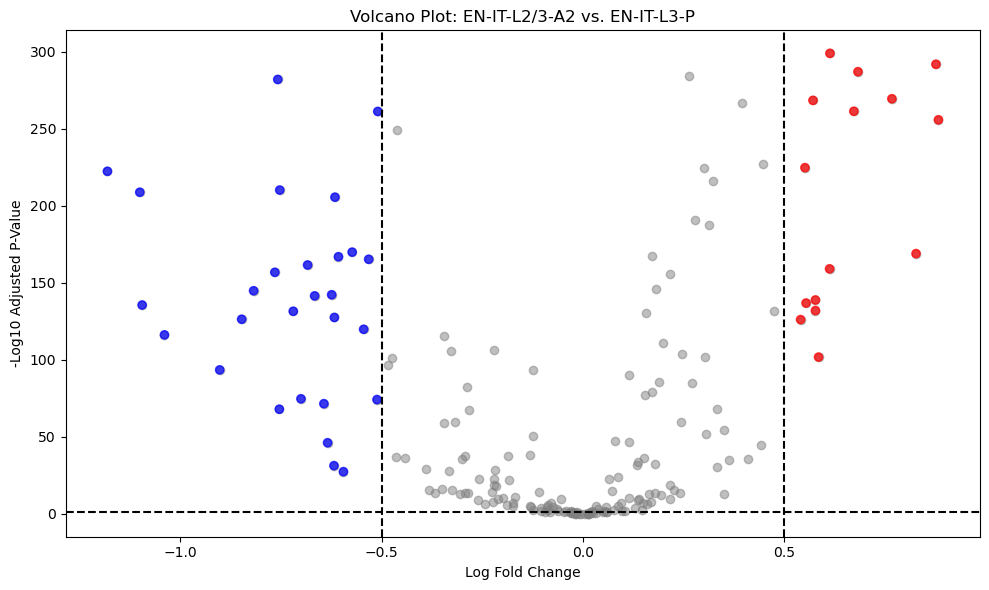

In [61]:
# Set thresholds for significance
sig_threshold = -np.log10(0.1)  # Adjusted p-value threshold
lfc_threshold = 0.5  # Log fold change threshold

# Define offsets for text labels from the points
# The offsets may need to be adjusted depending on your data's scale
x_offset = 0.5 # Adjust this value to move the text left/right
y_offset = 6    # Adjust this value to move the text up/down

plt.figure(figsize=(10, 6))

# Base scatter plot with finite values
plt.scatter(de_df['log_fold_change'], de_df['-log10_pval'], c='grey', alpha=0.5)

# Highlighted scatter plot for significant points
significant = de_df[(abs(de_df['log_fold_change']) > lfc_threshold) & (de_df['-log10_pval'] > sig_threshold)]
plt.scatter(significant['log_fold_change'], significant['-log10_pval'],
            c=['red' if x > lfc_threshold else 'blue' for x in significant['log_fold_change']],
            alpha=0.7)

# Add threshold lines
plt.axhline(y=sig_threshold, color='black', linestyle='--')
plt.axvline(x=-lfc_threshold, color='black', linestyle='--')
plt.axvline(x=lfc_threshold, color='black', linestyle='--')

# Label the top 10 significant genes with an offset and draw lines
for _, row in de_df.iterrows():
    color = 'red' if row['log_fold_change'] > 0 else 'blue'
    text_x = row['log_fold_change'] + x_offset
    text_y = row['-log10_pval'] + y_offset
    #plt.text(text_x, text_y, row['gene'], fontsize=8, color=color, ha='right', va='center')

# Axes labels
plt.xlabel('Log Fold Change')
plt.ylabel('-Log10 Adjusted P-Value')
# Title
plt.title('Volcano Plot: EN-IT-L2/3-A2 vs. EN-IT-L3-P')

plt.tight_layout()
plt.savefig("volcano_plot1_NEW.pdf")
plt.show()

In [30]:
plt.close()